### Natural Language Processing WORK TOKENIZER

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from collections import Counter


nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/jiten/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Rules:

`Punctuations` should be separated but NOT discarded.  Also:
- You only separate punctuations that occurred only at the leading or trailing positions of a word.  If a punctuation (or punctuations) occur(s) within a word, you do not separate the word.  For example, "\\$3.19" should be separated into "\\$" and "3.19".  If NLTK word_tokenize() didn't adhere to it for any instance, do NOT take NLTK's tokenization and override yourself by separating ONLY the leading and the trailing punctuations.

- If a consecutive (leading and trailing) punctuations were tokenized as one token (e.g. "...",  "--") by NLTK word_tokenize(), treat them as one token/word.

- Or if a consecutive (leading and trailing) punctuations were tokenized as multiple tokens (e.g. "!", "!" from "!!") by NLTK word_tokenize(), treat them as multiple tokens (i.e, as is).

- Also if a word ends with a period (.), you don't have to check if it is a known acronym (e.g. "mr.", "m.p.g.", "e.g.", "etc.").  Just use NLTK's tokenization/split.
 
`Contractions` must be expanded and converted to the root/lemma tokens.  Although some contractions are ambiguous (e.g. "they'd" could be "they would" or "they had"), in this assignment you can make these simplifying assumptions.

NLTK word_tokenize() splits contractions at the quote character (') or special cases such as "n't".  For example, it splits "they'd" to two tokens 'they' and "'d" , and "don't" to 'do' and  "n't".

Contractions to convert:

- "n't" -- assume "not" for all instances (e.g. "don't" -> "do" and "not"), EXCEPT for these special cases (where you'll need to look at the preceding token to determine):
- won't -- "will" and "not"
- can't -- "can" and "not"
- shan’t -- "shall" and "not"
- "'ll" -- assume "will" for all instances; e.g. "they'll" -> "they" and "will"
- " 've" -- assume "have" for all instances; e.g. "they've" -> "they" and "have"
- "'d" -- assume "would" for all instances; e.g. "they'd" -> "they" and "would"
- "'re" -- assume "are" for all instances; e.g. "they're" -> "they" and "are"
- "'s " -- assume possessive (i.e., an apostrophe-s); e.g. "phone's" -> "phone" and "'s" ==> thus no change, EXCEPT for these special cases:
    - "let's" -- "let" and "us"
    - obvious contraction of "is" (mostly used with a singular pronoun or a wh-word; e.g. "it's" -> "it" and "is").  In this assignment, apply this rule to these words: "he's", "she's", "it's", "that's", "here's" and "there's", "what's", "when's", "where's", "which's", "who's" and "how's". 
- other special cases:
    - i'm -- "i" and "am".

Note that, if a word contains multiple contractions (e.g. "shouldn't've"), you must separate ALL of them (e.g. "should", "not", "have").

In [2]:
def getData(lines):
    
    # variable to hold the string
    data = ""
    paragraphs = 0
    in_paragraph = False

    # loop through the lines and create the string
    # make it lower case
    for line in lines:
        line_strip = line.strip()
        if line_strip != '':
            data = data + line_strip.lower() + " "
            if not in_paragraph:
                # Start of a new paragraph
                paragraphs += 1
                in_paragraph = True
        else:
            in_paragraph = False
                
    
    data = data.strip()
    return data, paragraphs


# contraction dictionary to map to the rules
# contractions_dict = {
#     "n't": "not", "'ll": "will", "'ve": "have", "'d": "would", "'re": "are", 
#     "i'm": "i am", "won't": "will not", 
#     "can't": "can not", "shan't": "shall not"
# }

contractions_dict = {
    "n't": "not", "'ll": "will", "'ve": "have", "'d": "would", "'re": "are", "'m": "am",
    "'s": "'s", "let's": "let us", "i'm": "i am", "won't": "will not",
    "wouldn't": "would not", "can't": "can not", "shan't": "shall not", 
    "he's": "he is", "she's": "she is", "it's": "it is", "that's": "that is", 
    "here's": "here is", "there's": "there is", "what's": "what is", 
    "when's": "when is", "where's": "where is", "which's": "which is", 
    "who's": "who is", "how's": "how is"
}

# Function to handle contraction expansion
# if the toke is in contraction dict then epand it as per the mapping
def expand_contractions(tokens):
    expanded_tokens = []
    for token in tokens:
        if token == "n't" and expanded_tokens and expanded_tokens[-1] in ["do", "does", "did", "is", "are", 
                                                                        "was", "were", "has", "have", "had", 
                                                                        "ca", "would", "should", "could", 'wo', 'sha']:
            # won't will be converted to will not
            # and shan't will be converted to shall not
            if expanded_tokens[-1] == 'wo':
                expanded_tokens[-1] = 'will'
            if expanded_tokens[-1] == 'sha':
                expanded_tokens[-1] = 'shall'
            if expanded_tokens[-1] == 'ca':
                expanded_tokens[-1] = 'can'
                
            expanded_tokens.append("not")
        elif token == "'s" and expanded_tokens and expanded_tokens[-1] in ["let"]:
            # let's will be converted to let us
            expanded_tokens.append("us")
        elif token == "'s" and expanded_tokens and expanded_tokens[-1] in ["it", "that", "here", "there", "what",
                                                                          "when", "where", "which", "who", "how",
                                                                          "he", "she"]:
            # 's will be converted to is
            expanded_tokens.append("is")
        elif token[0] == "'" and len(token) > 2 and token not in contractions_dict:
            # anything that has a ' in the begining will be divided 
            # ex : 'have to ' and have
            #print(token)
            expanded_tokens.append(token[0])
            expanded_tokens.append(token[1:])
        elif token in contractions_dict:
            expanded_tokens.extend(contractions_dict[token].split())
        elif token.endswith(".") and len(token) > 1 and token[-1] != token[-2]:
            #print(token) 
            expanded_tokens.append(token[:-1])
            expanded_tokens.append(token[-1])
        else:
            expanded_tokens.append(token)
    return expanded_tokens

In [3]:
def processFile(fileName, typ=None):
    
    # read the sample input file
    if typ == 'utf-8':
        f = open(fileName, 'r', encoding='utf-8')
    else:
        f = open(fileName, 'r')

    lines = f.readlines()
    
    f.close()
    
    # prepare the data and ge tthe paragraph details
    data, paragraphs = getData(lines)
    #print(f"No of Paragraphs :: {paragraphs}")
    
    # check the no of sentences
    sentences = len(sent_tokenize(data))

    #print(f"Total no of sentences :: {sentences}")
    
    # tokenize using word_tokenize
    tokens = word_tokenize(data)
    
    # expand contraction
    tokens_c = expand_contractions(tokens)
    
    # get the total no of tokens
    total_tokens = len(tokens_c)
    
    # total unique tokens
    unique_tokens = len(np.unique(tokens_c))
    
    # preare the counter and sorted dictionary for output
    word_counter = Counter(tokens_c)
    
    # Sort first alphabetically (linguistically), then by frequency in descending order
    sorted_word_counter = sorted(word_counter.items(), key=lambda x: (-x[1], x[0]))
    
    sorted_word_counter = dict(sorted_word_counter)
    
    return data, paragraphs, sentences, total_tokens, unique_tokens, sorted_word_counter, tokens, tokens_c

In [4]:
def writeOutput(num_paragraphs, num_sentences, num_tokens, num_unique_tokens, sorted_word_counter, output_file):
    
    with open(output_file, 'w') as file:
        # write summary
        file.write(f"# of paragraphs: {num_paragraphs}\n")
        file.write(f"# of sentences: {num_sentences}\n")
        file.write(f"# of tokens: {num_tokens}\n")
        file.write(f"# of unique tokens: {num_unique_tokens}\n")
        file.write("=" * 20 )
    
        # Print token frequencies
        for i, (token, count) in enumerate(sorted_word_counter.items(), start=1):
            file.write(f"\n{i}: {token}  {count}")

In [5]:
data, paragraphs, sentences, total_tokens, unique_tokens, sorted_word_counter, tokens, tokens_c = processFile(
    "sample_2024.txt")

In [6]:
# show the sample data to be processed
data

'here are some random sentences.  let\'s parse them :)  that\'ll be fun!! if you can really see the future, you could\'ve prevented all of this! i just have to report a really beautiful example i heard on my favorite public radio station on feb. 16 during their recent fund drive. i\'ve met a member of their developmember staff and been interviewed by her, which\'s to say it\'s awesome.  i won\'t name her simply because she might be "embarrassed," and i wouldn\'t want to cause that. this powerful true story of human decency and courage, so rare in the tragic annals of world war ii, is badly spoiled by terrible writing. many of the reviews here explain just what makes the writing so bad (e.g., john sollami\'s 3-star review and comments on it) so i shan\'t and won\'t do that here.  it\'s repetitive, slow, not interesting and i think if i have to read the word "saumensch" or "saukerl" one more time, i\'ll be done with this book forever.  because you haven\'t sopped up enough of that yet in

In [7]:
# write the data to the output file
writeOutput(paragraphs, sentences, total_tokens, unique_tokens, sorted_word_counter, 'output1.txt')

In [8]:
# verify the file
f = open('output1.txt')

lines = f.readlines()

# Print only the first 10 lines
for i, line in enumerate(lines):
    if i < 10:
        print(line.strip())
    else:
        break  # Stop after printing 10 lines

# Close the file
f.close()

# of paragraphs: 8
# of sentences: 31
# of tokens: 567
# of unique tokens: 274
1: .  27
2: the  24
3: ,  19
4: is  14
5: not  14


In [9]:
data, paragraphs, sentences, total_tokens, unique_tokens, sorted_word_counter, tokens, tokens_c = processFile(
    "war-and-peace.txt", 'utf-8')

In [10]:
# write the data to the output file
writeOutput(paragraphs, sentences, total_tokens, unique_tokens, sorted_word_counter, 'output2.txt')

In [11]:
# verify the file
f = open('output2.txt')

lines = f.readlines()

# Print only the first 10 lines
for i, line in enumerate(lines):
    if i < 10:
        print(line.strip())
    else:
        break  # Stop after printing 10 lines

# Close the file
f.close()

# of paragraphs: 12169
# of sentences: 31911
# of tokens: 673101
# of unique tokens: 18395
1: ,  39882
2: the  34717
3: .  24992
4: and  22289
5: to  16750


In [15]:
def plot_zipf_law(word_frequencies):
    # Sort the word frequencies in descending order
    sorted_frequencies = sorted(word_frequencies.values(), reverse=True)
    
    # Calculate the ranks (1, 2, 3, ...)
    ranks = np.arange(1, len(sorted_frequencies) + 1)
    
    # Compute the natural logarithm of the frequencies
    log_frequencies = np.log(sorted_frequencies)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, log_frequencies, marker='o', linestyle='-', color='b', label="Log of Frequencies")
    
    # Set labels and title
    plt.xlabel('Rank')
    plt.ylabel('Log(Frequency)')
    plt.title("Zipf's Law: Log(Frequency) vs Rank")
    
    # Show the grid and legend
    plt.grid(True)
    plt.legend()
    
    # Display the plot
    plt.show()

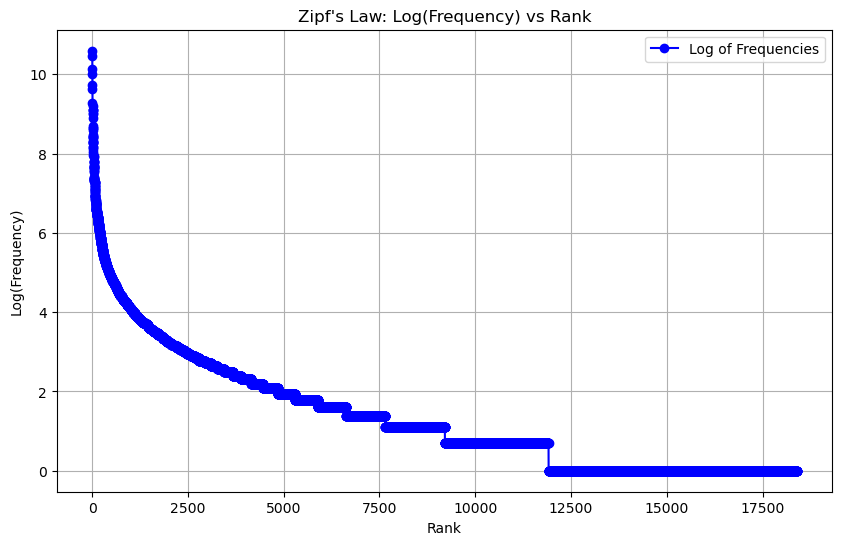

In [16]:
plot_zipf_law(sorted_word_counter)